# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [6]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [70]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# Create 'switches' to turn off and on for each question and combinations of features:
EXTRA_POS = False  # Q4 (and Q5)
EXTRA_SUFFIXES = False  # Q5
PREFIXES = False # Q5
PREVIOUS_TOKENS_TAGS = False # Q5
FOLLOWING_TOKENS_TAGS = False # Q5

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # SOLUTION
    # extra features for POS Q4 (+ Q5)
    if EXTRA_POS:
        token, pos = token.split("__")[0], token.split("__")[1]
        feature_list.append("POS_" + pos)
    
    # SOLUTION
    # extra features Q5
    if EXTRA_SUFFIXES:
        for x in range(4, len(token)):
            feature_list.append("SUF_" + token[-x:])
    if PREFIXES:
        for x in range(1, len(token)):
            feature_list.append("PREF_" + token[:x])
    
    if PREVIOUS_TOKENS_TAGS:
        for i in range(idx-2,idx):
            if i >= 0:
                pre_token = tokens[i]
                pre_token, pre_pos = pre_token.split("__")[0], pre_token.split("__")[1]
                feature_list.append("PRETOKEN_-{0}_".format(idx-i) + pre_token)
                if EXTRA_POS:
                    feature_list.append("PREPOS_-{0}_".format(idx-i) + pre_pos)
            else:
                feature_list.append("PRETOKEN_-{0}_".format(idx-i) + "<s>")
                if EXTRA_POS:
                    feature_list.append("PREPOS_-{0}_".format(idx-i) + "<s>")
    
    if FOLLOWING_TOKENS_TAGS:
        if idx < len(tokens)-1:
            post_token = tokens[idx+1]
            post_token, post_pos = post_token.split("__")[0], post_token.split("__")[1]
            feature_list.append("POSTTOKEN_" + post_token)
            if EXTRA_POS:
                feature_list.append("POSTPOS_" + post_pos)
        else:
            feature_list.append("POSTTOKEN_</s>")
            if EXTRA_POS:
                feature_list.append("POSTPOS_</s>")

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [64]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...


KeyboardInterrupt: 

In [11]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')


In [12]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [13]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [14]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [15]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [16]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [17]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [18]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

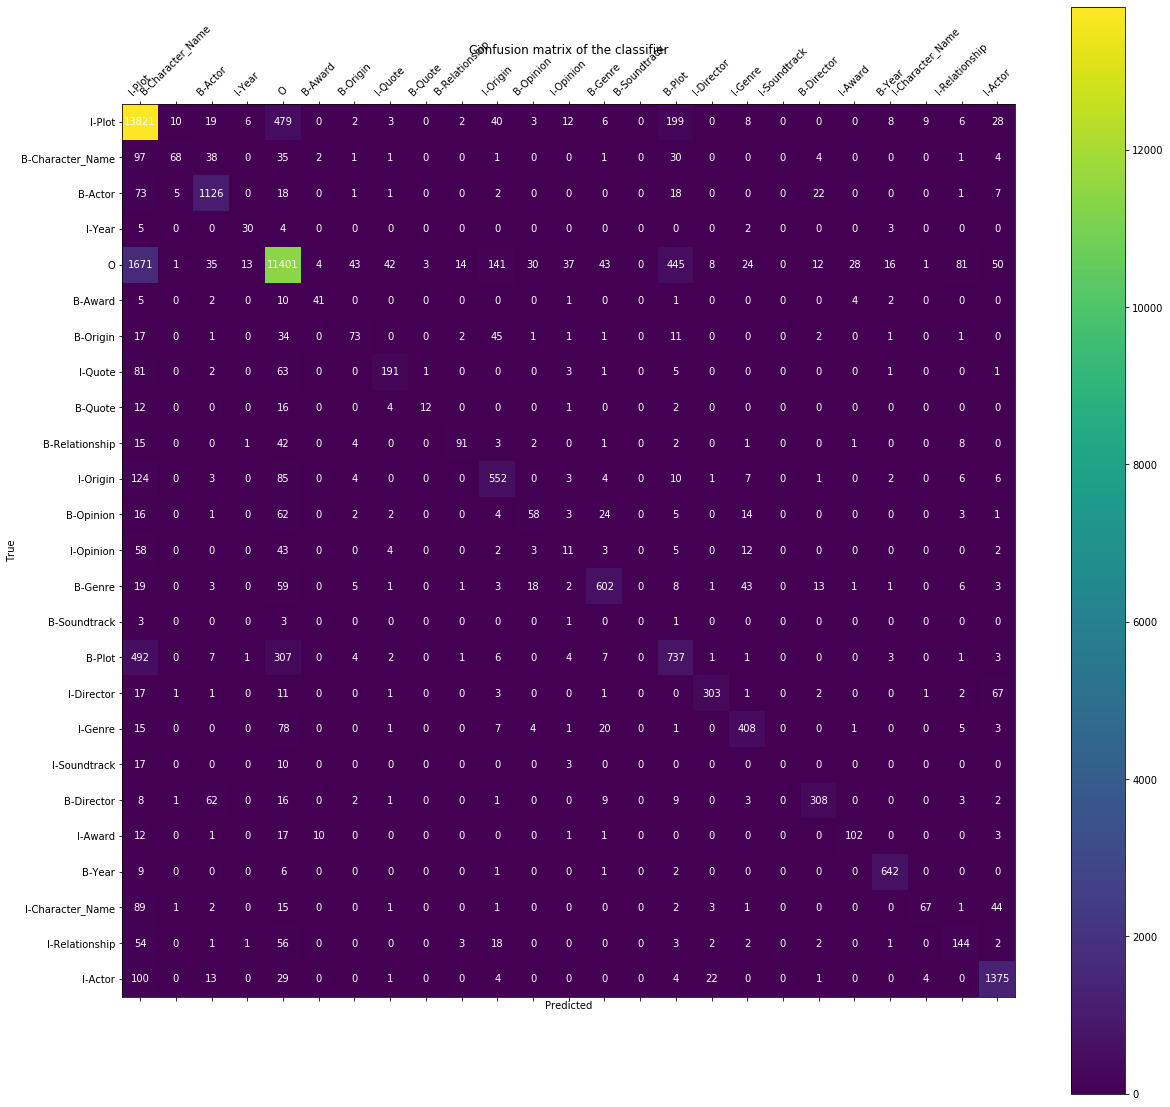

In [19]:
confusion_matrix_heatmap(y_test, preds)

In [20]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [21]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [22]:
print_transition_weights(ct._tagger.info().transitions.items())

8.730936 B-Actor  -> I-Actor
8.345982 B-Plot   -> I-Plot
8.062881 B-Director -> I-Director
7.851024 B-Origin -> I-Origin
7.728286 I-Plot   -> I-Plot
7.557302 I-Quote  -> I-Quote
7.400516 B-Character_Name -> I-Character_Name
7.347592 I-Origin -> I-Origin
7.270472 B-Relationship -> I-Relationship
7.168646 B-Quote  -> I-Quote
7.019230 I-Relationship -> I-Relationship
6.874782 I-Soundtrack -> I-Soundtrack
6.792831 I-Opinion -> I-Opinion
6.739054 B-Genre  -> I-Genre
6.682199 B-Soundtrack -> I-Soundtrack
6.580473 B-Award  -> I-Award
6.441732 B-Opinion -> I-Opinion
6.428294 I-Award  -> I-Award
6.362482 I-Genre  -> I-Genre
6.348037 I-Actor  -> I-Actor
6.225893 I-Character_Name -> I-Character_Name
5.430455 I-Director -> I-Director
4.809019 I-Year   -> I-Year
4.082752 B-Year   -> I-Year
3.773733 B-Character_Name -> B-Plot
3.563915 O        -> O
3.562699 I-Character_Name -> B-Plot
3.277145 O        -> B-Plot
3.199695 B-Plot   -> B-Character_Name
3.091597 B-Opinion -> B-Genre
3.030532 O        -> 

In [23]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [24]:
print_most_predictive_state_features(ct._tagger.info().state_features.items(),top_k=20)

5.191234 B-Year   HAS_NUM
4.378852 B-Genre  WORD_animated
4.376891 I-Year   WORD_s
3.280298 B-Genre  WORD_thriller
2.998992 B-Quote  WORD_i
2.986864 I-Genre  WORD_animated
2.968166 B-Genre  WORD_action
2.913375 B-Plot   WORD_a
2.910979 B-Opinion WORD_blockbuster
2.682290 B-Award  WORD_oscar
2.667863 B-Genre  WORD_animation
2.596255 B-Relationship SUF_uel
2.572959 B-Director WORD_disney
2.563763 B-Opinion WORD_masterpiece
2.552841 I-Genre  WORD_fiction
2.542230 B-Award  SUF_car
2.527780 B-Relationship WORD_remake
2.471652 B-Actor  WORD_cher
2.439679 B-Genre  WORD_horror
2.427487 I-Genre  WORD_white


# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


In [25]:
# Solution Q1
split_point = int(0.8 * len(training_data))
new_training_data = training_data[:split_point]
heldout_data = training_data[split_point:]
print(len(new_training_data), "training instances")
print(sum([len(sent) for sent in new_training_data]), "training words")
print(len(heldout_data), "heldout instances")
print(sum([len(sent) for sent in heldout_data]), "heldout words")

6252 training instances
127519 training words
1564 heldout instances
31304 heldout words


In [26]:
# Solution Q1
# Train the CRF BIO-tag tagger on the new training data (80% of original)
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features) #, training_opt={"feature.minfreq":4, "c1":0.1, "c2":0.1})  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [27]:
# Solution Q1
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

1564 instances
31304 words


In [28]:
# Solution Q1
# Test on the heldout data (20% of training data)
print("testing tagger on heldout data...")
preds = []
y_test = []
for sent in heldout_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger on heldout data...
done


In [29]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.66      0.74       456
         I-Ge

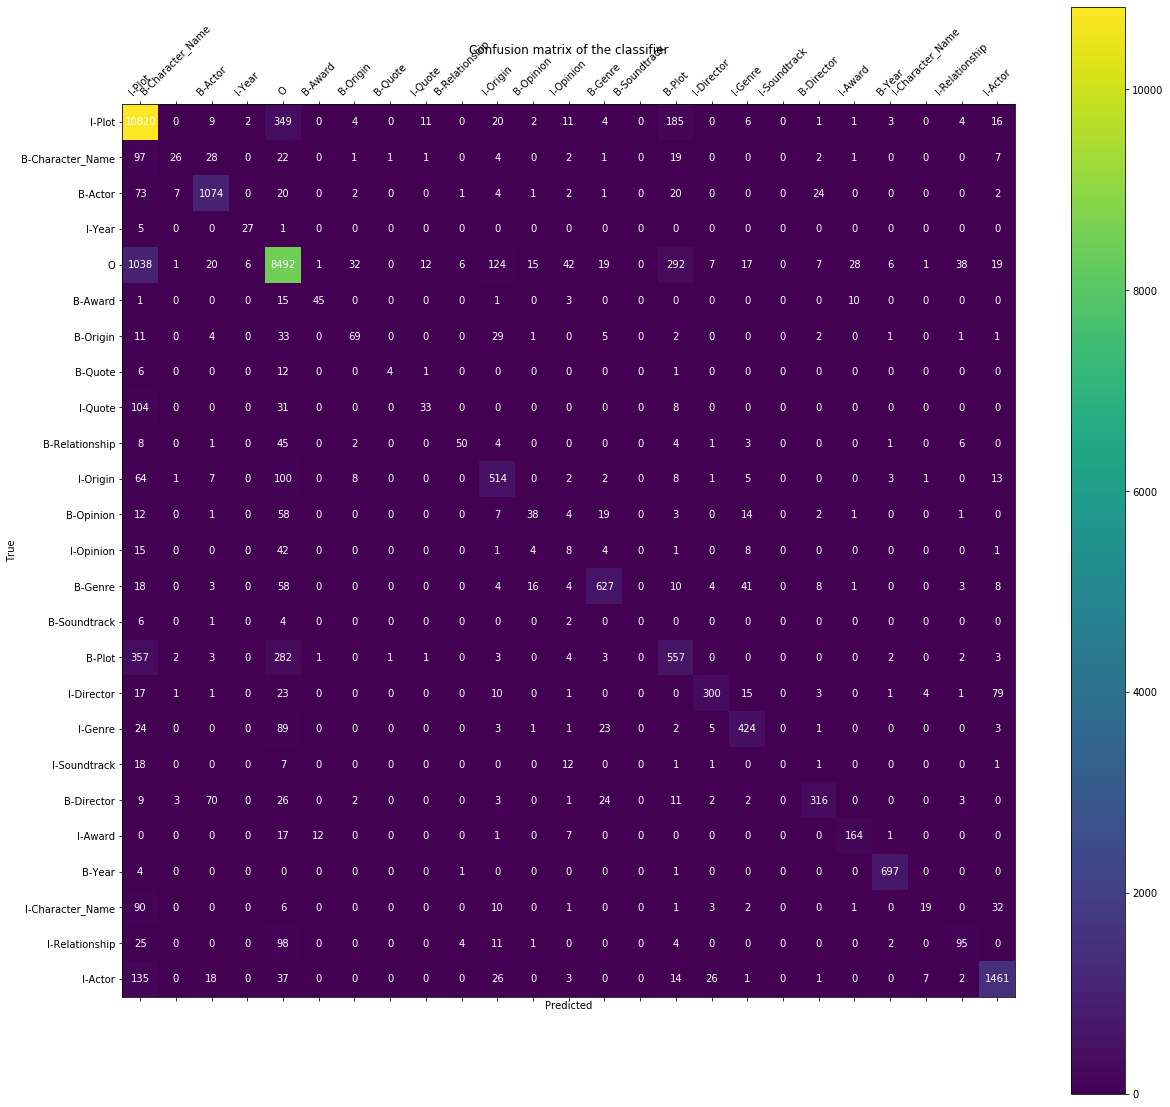

In [30]:
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [31]:
# answers 2 and 3

# Identify lowest precision and recall classes from results above on 20% heldout data
# rank by precision lowest to highest:
category_scores = [(k, v) for k, v in filter(lambda x: x[0] not in \
                         ["accuracy", "macro avg", "weighted avg"],
                        classification_report(y_test, preds, output_dict=True).items())]

print("precision ****")
lowest_precision  = []
for label, scores in sorted(category_scores,
                            key=lambda x: x[1]["precision"]):
    print(label, scores['precision']) 
    if len(lowest_precision)<5:
        lowest_precision.append(label)
        
print("\nrecall ****")              
lowest_recall  = []
for label, scores in sorted(category_scores,
                            key=lambda x: x[1]["recall"]):
    print(label, scores['recall']) 
    if len(lowest_recall)<5:
        lowest_recall.append(label)


#lowest_precision = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "B-Opinion", "B-Plot"]
#lowest_recall = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "I-Character_Name", "B-Character_Name"]
print("lowest precision classes", lowest_precision)
print("lowest recall classes", lowest_recall)


/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision ****
B-Soundtrack 0.0
I-Soundtrack 0.0
I-Opinion 0.07272727272727272
B-Opinion 0.4810126582278481
B-Plot 0.4868881118881119
I-Quote 0.559322033898305
B-Origin 0.575
I-Character_Name 0.59375
I-Relationship 0.6089743589743589
B-Character_Name 0.6341463414634146
I-Origin 0.6598202824133504
B-Quote 0.6666666666666666
B-Award 0.7627118644067796
I-Year 0.7714285714285715
I-Genre 0.7881040892193308
I-Award 0.7922705314009661
B-Relationship 0.8064516129032258
I-Plot 0.8350698464150652
B-Genre 0.8565573770491803
I-Director 0.8571428571428571
B-Director 0.8586956521739131
O 0.8606465997770345
B-Actor 0.8661290322580645
I-Actor 0.8876063183475091
B-Year 0.9721059972105998

recall ****
B-Soundtrack 0.0
I-Soundtrack 0.0
I-Opinion 0.09523809523809523
I-Character_Name 0.11515151515151516
B-Character_Name 0.12264150943396226
B-Quote 0.16666666666666666
I-Quote 0.1875
B-Opinion 0.2375
I-Relationship 0.3958333333333333
B-Relationship 0.4
B-Origin 0.4339622641509434
B-Plot 0.4561834561834562
B-

In [50]:
def print_word_tags_with_errors(tokens, true_tags, pred_tags, error_indices):
    """Print out the words, predictions and ground truth tags for an instance.
    Mark those with an error in them as indicated by position in error_indices.
    """
    for i, token, y_tag, pred_tag in zip(range(0,len(tokens)), tokens, true_tags, pred_tags):
        marked = "<-" if i in error_indices else ""
        print(f'{token:15s}{y_tag:12s}{pred_tag:8s}{marked}')



def test(crf_tagger, data, print_fps=True, print_fns=True):
    """Returns a list of predictions and list of ground-truth labels.
    Also prints out false positives/negatives for a list of classes"""
    print("testing tagger...")
    preds = []
    y_test = []
    for sent in data:
        sent_words = [s[0] for s in sent]
        sent_preds = [x[1] for x in crf_tagger.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]

        # Get the false positives in the sentence
        if print_fps:
            for fp in lowest_precision:
                positions_pred = [i for i, x in enumerate(sent_preds) if x==fp]
                if positions_pred == []:
                    continue
                positions_true = [i for i, x in enumerate(sent_true) if x==fp]
                fps = set(positions_pred) - set(positions_true)
                if len(fps)>0:
                    print("false positive(s) for:", fp)
                    #print("Positions in sequences:", fps)
                    #print("Ground truth:", sent)
                    #print("Predictions:", sent_preds)
                    print_word_tags_with_errors(sent_words, sent_true, sent_preds, fps)
                    print("*" * 30)
        if print_fns:
            # Get the false negatives in the sentence
            for fn in lowest_recall:
                positions_true = [i for i, x in enumerate(sent_true) if x==fn]
                if positions_true == []:
                    continue
                positions_pred = [i for i, x in enumerate(sent_preds) if x==fn]
                fns = set(positions_true) - set(positions_pred)
                if len(fns)>0:
                    print("false negative(s) for:", fn)
                    #print("Positions in sequence:", fns)
                    #print("Ground truth:", sent)
                    #print("Predictions:", sent_preds)
                    print_word_tags_with_errors(sent_words, sent_true, sent_preds, fns)
                    print("*" * 30)
        preds.extend(sent_preds)
        y_test.extend(sent_true)
    print("done")
    return preds, y_test

In [51]:
preds, y_test = test(ct, heldout_data)

testing tagger...
false positive(s) for: B-Plot
on             B-Plot      O       
a              I-Plot      B-Plot  <-
vacation       I-Plot      I-Plot  
in             I-Plot      I-Plot  
paris          I-Plot      I-Plot  
one            I-Plot      I-Plot  
of             I-Plot      I-Plot  
three          I-Plot      I-Plot  
travelers      I-Plot      I-Plot  
is             I-Plot      I-Plot  
mistaken       I-Plot      I-Plot  
for            I-Plot      I-Plot  
a              I-Plot      I-Plot  
british        I-Plot      I-Plot  
heiress        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
one            O           O       
of             O           O       
the            O           O       
first          O           O       
disney         B-Director  B-Genre 
animated       B-Genre     I-Genre 
films          O           O       
with           O           O       
beautiful      O           B-Plot  <-
images         O       

do             O           I-Plot  
n              O           I-Plot  
t              O           I-Plot  
take           O           I-Plot  
short          O           I-Plot  
cuts           O           I-Plot  
******************************
false positive(s) for: B-Plot
the            O           O       
main           O           O       
character      O           O       
of             O           O       
this           O           O       
animated       B-Genre     B-Genre 
film           O           O       
is             O           O       
a              O           B-Plot  <-
fiery          B-Plot      I-Plot  
red            I-Plot      I-Plot  
haired         I-Plot      I-Plot  
princess       I-Plot      I-Plot  
who            I-Plot      I-Plot  
loves          I-Plot      I-Plot  
archery        I-Plot      I-Plot  
and            I-Plot      I-Plot  
has            I-Plot      I-Plot  
mom            I-Plot      I-Plot  
issues         I-Plot      I-Plot  
*

false positive(s) for: B-Plot
this           O           O       
2010           B-Year      B-Year  
american       B-Genre     B-Genre 
supernatural   I-Genre     I-Genre 
horror         I-Genre     I-Genre 
film           O           O       
starred        O           O       
sprague        B-Actor     B-Plot  <-
grayden        I-Actor     I-Plot  
as             O           I-Plot  
kristi         B-Character_NameI-Plot  
and            O           I-Plot  
molly          B-Actor     I-Plot  
ephraim        I-Actor     I-Plot  
as             O           I-Plot  
ali            B-Character_NameI-Plot  
******************************
false negative(s) for: B-Character_Name
this           O           O       
2010           B-Year      B-Year  
american       B-Genre     B-Genre 
supernatural   I-Genre     I-Genre 
horror         I-Genre     I-Genre 
film           O           O       
starred        O           O       
sprague        B-Actor     B-Plot  
grayden        I-Actor   

stars          O           O       
johnny         B-Actor     B-Actor 
depp           I-Actor     I-Actor 
as             O           O       
a              O           B-Plot  <-
timid          B-Plot      I-Plot  
chameleon      I-Plot      I-Plot  
who            I-Plot      I-Plot  
finds          I-Plot      I-Plot  
courage        I-Plot      I-Plot  
in             I-Plot      I-Plot  
the            I-Plot      I-Plot  
desert         I-Plot      I-Plot  
******************************
false positive(s) for: I-Opinion
this           O           O       
computer       B-Genre     B-Genre 
animated       I-Genre     I-Genre 
comedy         I-Genre     I-Genre 
features       O           O       
the            O           O       
voice          O           O       
of             O           O       
steve          B-Actor     B-Actor 
carrell        I-Actor     I-Actor 
as             O           O       
the            O           O       
villainous     O           B-Opini

false positive(s) for: B-Plot
this           O           O       
recent         O           O       
thriller       B-Genre     B-Genre 
portrays       O           O       
a              O           B-Plot  <-
blonde         B-Plot      I-Plot  
young          I-Plot      I-Plot  
girl           I-Plot      I-Plot  
as             I-Plot      I-Plot  
a              I-Plot      I-Plot  
killer         I-Plot      I-Plot  
trained        I-Plot      I-Plot  
in             I-Plot      I-Plot  
the            I-Plot      I-Plot  
wilderness     I-Plot      I-Plot  
by             I-Plot      I-Plot  
her            I-Plot      I-Plot  
father         I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
this           O           O       
road           B-Genre     O       
trip           I-Genre     O       
comedy         I-Genre     B-Genre 
features       O           O       
robert         B-Actor     B-Actor 
downey         I-Actor     I-Actor 
jr     

where          O           O       
he             O           O       
says           O           O       
i              B-Quote     O       
coulda         I-Quote     B-Plot  <-
been           I-Quote     I-Plot  
a              I-Quote     I-Plot  
contender      I-Quote     I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
s              O           O       
the            O           O       
name           O           O       
of             O           O       
that           O           O       
martial        B-Genre     O       
film           I-Genre     O       
by             O           O       
ang            B-Director  B-Director
lee            I-Director  I-Director
where          O           O       
chow           B-Actor     B-Actor 
yun            I-Actor     I-Actor 
fat            I-Actor     B-Plot  <-
hunts          B-Plot      I-Plot  
for            I-Plot      I-Plot  
a              I-Plot      I-Pl

false positive(s) for: B-Plot
what           O           O       
1970           B-Year      B-Year  
movie          O           O       
takes          O           B-Plot  <-
place          O           I-Plot  
in             B-Plot      I-Plot  
1825           I-Plot      I-Plot  
and            I-Plot      I-Plot  
centers        I-Plot      I-Plot  
around         I-Plot      I-Plot  
an             I-Plot      I-Plot  
english        I-Plot      I-Plot  
aristocrat     I-Plot      I-Plot  
who            I-Plot      I-Plot  
is             I-Plot      I-Plot  
captured       I-Plot      I-Plot  
by             I-Plot      I-Plot  
indians        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
1970           B-Year      B-Year  
robert         B-Director  B-Director
altman         I-Director  I-Director
movie          O           O       
about          B-Plot      O       
the            I-Plot      O       
kor

robert         B-Character_NameB-Actor <-
kincaid        I-Character_NameI-Actor 
and            O           O       
meryl          B-Actor     B-Actor 
streep         I-Actor     I-Actor 
as             O           O       
his            B-Plot      O       
short          O           B-Opinion
lived          O           I-Opinion
love           O           I-Opinion
interest       O           I-Opinion
******************************
false positive(s) for: B-Plot
what           O           O       
1995           B-Year      B-Year  
family         B-Genre     B-Genre 
film           O           O       
centers        O           B-Plot  <-
around         O           I-Plot  
a              O           I-Plot  
pig            B-Plot      I-Plot  
raised         I-Plot      I-Plot  
by             I-Plot      I-Plot  
sheep          I-Plot      I-Plot  
dogs           I-Plot      I-Plot  
with           I-Plot      I-Plot  
a              I-Plot      I-Plot  
little         I-Plot  

cia            I-Plot      I-Plot  
special        I-Plot      I-Plot  
forces         I-Plot      I-Plot  
team           I-Plot      I-Plot  
that           I-Plot      I-Plot  
was            I-Plot      I-Plot  
betrayed       I-Plot      I-Plot  
and            I-Plot      I-Plot  
left           I-Plot      I-Plot  
for            I-Plot      I-Plot  
dead           I-Plot      I-Plot  
by             I-Plot      I-Plot  
their          I-Plot      I-Plot  
superiors      I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
2010           B-Year      B-Year  
movie          O           O       
features       O           O       
the            B-Plot      O       
story          I-Plot      B-Plot  <-
of             I-Plot      I-Plot  
a              I-Plot      I-Plot  
1973           I-Plot      I-Plot  
triple         I-Plot      I-Plot  
crown          I-Plot      I-Plot  
winner         I-Plot      I-Plot  
*

hathaway       I-Actor     I-Actor 
as             O           O       
cat            B-Character_NameO       <-
woman          I-Character_NameO       
and            O           O       
tom            B-Actor     B-Actor 
hardy          I-Actor     I-Actor 
as             O           O       
bane           B-Character_NameB-Character_Name
******************************
false positive(s) for: B-Plot
what           O           O       
2012           B-Year      B-Year  
thriller       B-Genre     B-Genre 
depicts        B-Plot      O       
a              I-Plot      B-Plot  <-
police         I-Plot      I-Plot  
force          I-Plot      I-Plot  
in             I-Plot      I-Plot  
a              I-Plot      I-Plot  
midwestern     I-Plot      I-Plot  
town           I-Plot      I-Plot  
searching      I-Plot      I-Plot  
for            I-Plot      I-Plot  
a              I-Plot      I-Plot  
killer         I-Plot      I-Plot  
santa          I-Plot      I-Plot  
claus          

false positive(s) for: B-Plot
what           O           O       
film           O           O       
broke          O           O       
global         O           B-Plot  <-
records        O           I-Plot  
with           O           I-Plot  
its            O           I-Plot  
budget         O           I-Plot  
and            O           I-Plot  
showed         O           I-Plot  
people         O           I-Plot  
a              B-Plot      I-Plot  
new            I-Plot      I-Plot  
universe       I-Plot      I-Plot  
with           I-Plot      I-Plot  
a              I-Plot      I-Plot  
mysterious     I-Plot      I-Plot  
tree           I-Plot      I-Plot  
and            I-Plot      I-Plot  
blue           I-Plot      I-Plot  
folks          I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
film           O           O       
directed       O           O       
by             O           O       
david  

false positive(s) for: B-Plot
what           O           O       
is             O           O       
that           O           O       
movie          O           O       
starring       O           O       
keanu          B-Actor     B-Actor 
reeves         I-Actor     I-Actor 
as             O           O       
an             O           B-Plot  <-
lapd           B-Plot      I-Plot  
cop            I-Plot      I-Plot  
who            I-Plot      I-Plot  
has            I-Plot      I-Plot  
to             I-Plot      I-Plot  
stop           I-Plot      I-Plot  
bus            I-Plot      I-Plot  
from           I-Plot      I-Plot  
blowing        I-Plot      I-Plot  
up             I-Plot      I-Plot  
and            O           O       
also           O           O       
starring       O           O       
sandra         B-Actor     B-Actor 
bullock        I-Actor     I-Actor 
******************************
false positive(s) for: B-Plot
what           O           O       
is     

false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
2009           B-Year      B-Year  
science        B-Genre     B-Genre 
fiction        I-Genre     I-Genre 
film           O           O       
directed       O           O       
by             O           O       
james          B-Director  B-Director
cameron        I-Director  I-Director
set            O           B-Plot  <-
in             O           I-Plot  
the            O           I-Plot  
mid            B-Year      I-Plot  
22             I-Year      I-Plot  
century        I-Year      I-Plot  
on             B-Plot      I-Plot  
the            I-Plot      I-Plot  
planet         I-Plot      I-Plot  
pandora        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
2010           B-Year      B-Year  
ali

false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
disney         B-Director  B-Director
movie          O           O       
that           O           O       
features       O           O       
lifelike       B-Plot      O       
cars           I-Plot      B-Plot  <-
that           I-Plot      I-Plot  
can            I-Plot      I-Plot  
talk           I-Plot      I-Plot  
and            I-Plot      I-Plot  
interact       I-Plot      I-Plot  
with           I-Plot      I-Plot  
each           I-Plot      I-Plot  
other          I-Plot      I-Plot  
that           I-Plot      I-Plot  
also           I-Plot      I-Plot  
race           I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
documentary    B-Genre     B-Genre 
that           O           O       
is   

false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
movie          O           O       
starring       O           O       
matt           B-Actor     B-Actor 
damon          I-Actor     I-Actor 
in             B-Plot      O       
iraq           I-Plot      O       
where          I-Plot      O       
he             I-Plot      B-Plot  <-
discovers      I-Plot      I-Plot  
faulty         I-Plot      I-Plot  
intelligence   I-Plot      I-Plot  
and            I-Plot      I-Plot  
goes           I-Plot      I-Plot  
rogue          I-Plot      I-Plot  
******************************
false negative(s) for: I-Character_Name
what           O           O       
is             O           O       
the            O           O       
movie          O           O       
starring       O           O       
russell        B-Actor     B-Actor 
crowe          I-Actor     I-Actor 
as             O           O     

false positive(s) for: B-Plot
what           O           O       
is             O           O       
the            O           O       
paul           B-Actor     B-Actor 
giamatti       I-Actor     I-Actor 
and            O           O       
george         B-Actor     B-Actor 
clooney        I-Actor     I-Actor 
movie          O           O       
about          O           O       
a              O           B-Plot  <-
man            B-Plot      I-Plot  
who            I-Plot      I-Plot  
gets           I-Plot      I-Plot  
taught         I-Plot      I-Plot  
the            I-Plot      I-Plot  
lessons        I-Plot      I-Plot  
of             I-Plot      I-Plot  
dirty          I-Plot      I-Plot  
politics       I-Plot      I-Plot  
on             I-Plot      I-Plot  
the            I-Plot      I-Plot  
campaign       I-Plot      I-Plot  
trail          I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
is     

ebenezer       B-Character_NameI-Plot  <-
scrooge        I-Character_NameI-Plot  
as             B-Plot      I-Plot  
he             I-Plot      I-Plot  
is             I-Plot      I-Plot  
cold           I-Plot      I-Plot  
and            I-Plot      I-Plot  
eventually     I-Plot      I-Plot  
sees           I-Plot      I-Plot  
the            I-Plot      I-Plot  
error          I-Plot      I-Plot  
of             I-Plot      I-Plot  
his            I-Plot      I-Plot  
ways           I-Plot      I-Plot  
and            I-Plot      I-Plot  
reforms        I-Plot      I-Plot  
himself        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what           O           O       
movie          O           O       
centers        O           B-Plot  <-
around         O           I-Plot  
a              B-Plot      I-Plot  
masked         I-Plot      I-Plot  
killer         I-Plot      I-Plot  
trying         I-Plot      I-Plot  
to             I-Plot      

s              O           I-Year  
movie          O           O       
about          B-Plot      O       
a              I-Plot      B-Plot  <-
group          I-Plot      I-Plot  
of             I-Plot      I-Plot  
former         I-Plot      I-Plot  
college        I-Plot      I-Plot  
friends        I-Plot      I-Plot  
that           I-Plot      I-Plot  
get            I-Plot      I-Plot  
together       I-Plot      I-Plot  
for            I-Plot      I-Plot  
the            I-Plot      I-Plot  
weekend        I-Plot      I-Plot  
******************************
false positive(s) for: B-Opinion
what           O           O       
timeless       B-Opinion   O       
classic        I-Opinion   B-Opinion<-
starring       O           O       
clint          B-Actor     B-Actor 
eastwood       I-Actor     I-Actor 
does           O           O       
he             B-Plot      B-Plot  
carry          I-Plot      I-Plot  
a              I-Plot      I-Plot  
large          I-Plot      I-Pl

century        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
which          O           O       
quentin        B-Director  B-Director
tarantino      I-Director  I-Director
film           O           O       
told           O           B-Plot  <-
the            O           I-Plot  
story          B-Plot      I-Plot  
of             I-Plot      I-Plot  
two            I-Plot      I-Plot  
attempts       I-Plot      I-Plot  
to             I-Plot      I-Plot  
assassinate    I-Plot      I-Plot  
political      I-Plot      I-Plot  
leaders        I-Plot      I-Plot  
in             I-Plot      I-Plot  
nazi           I-Plot      I-Plot  
germany        I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
which          O           O       
steven         B-Director  B-Director
spielberg      I-Director  I-Director
film           O           O       
tells          O           O       
the            B-Plot      O       
stor

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [52]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [53]:
# solution to pre-process
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    words = [x[0] for x in example]
    pos_tags = [x[1] for x in posttagger.tag(words)]
    preprocessed_example = [("{0}__{1}".format(x[0], pos), x[1]) for x, pos in zip(example, pos_tags)]
    return preprocessed_example

In [54]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [55]:
training_data= [preProcess(example) for example in raw_training_data]

In [56]:
split_point = int(0.8 * len(training_data))
new_training_data = training_data[:split_point]
heldout_data = training_data[split_point:]
print(len(new_training_data), "instances")
print(sum([len(sent) for sent in new_training_data]), "words")

6252 instances
127519 words


In [57]:
# Turn on the 'POS switch' in the modified 'get_features' function above
EXTRA_POS = True

In [58]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
#ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4, "c1":0.1, "c2":0.1})  # initialize tagger with get_features function
ct = CRFTagger(feature_func=get_features)

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [59]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

1564 instances
31304 words


In [60]:
#lowest_precision = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "B-Opinion", "B-Plot"]
#lowest_recall = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "I-Character_Name", "B-Character_Name"]
preds, y_test = test(ct, heldout_data)

testing tagger...
false positive(s) for: B-Plot
on__IN         B-Plot      O       
a__DT          I-Plot      B-Plot  <-
vacation__NN   I-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
paris__NNP     I-Plot      I-Plot  
one__CD        I-Plot      I-Plot  
of__IN         I-Plot      I-Plot  
three__CD      I-Plot      I-Plot  
travelers__NNS I-Plot      I-Plot  
is__VBZ        I-Plot      I-Plot  
mistaken__VBN  I-Plot      I-Plot  
for__IN        I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
british__JJ    I-Plot      I-Plot  
heiress__NN    I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
one__CD        O           O       
of__IN         O           O       
the__DT        O           O       
first__JJ      O           O       
disney__NN     B-Director  B-Genre 
animated__JJ   B-Genre     I-Genre 
films__NNS     O           O       
with__IN       O           O       
beautiful__JJ  O           B-Plot  <-
images__NNS    O       

defense__NN    O           I-Plot  
attorney__NNP  O           I-Plot  
billy__NNP     B-Character_NameB-Actor 
flynn__NNP     I-Character_NameI-Actor <-
in__IN         O           O       
this__DT       O           O       
2002__NN       B-Year      B-Year  
musical__JJ    B-Genre     B-Genre 
******************************
false negative(s) for: B-Character_Name
richard__RB    B-Actor     B-Actor 
gere__RB       I-Actor     I-Actor 
took__VBD      O           B-Plot  
tap__NN        O           I-Plot  
dance__NN      O           I-Plot  
lessons__NNS   O           I-Plot  
for__IN        O           I-Plot  
three__CD      O           I-Plot  
months__NNS    O           I-Plot  
to__TO         O           I-Plot  
prepare__VB    O           I-Plot  
for__IN        O           I-Plot  
his__PRP$      O           I-Plot  
role__NN       O           I-Plot  
as__IN         O           I-Plot  
the__DT        O           I-Plot  
criminal__JJ   O           I-Plot  
defense__NN    O   

reddy__NN      I-Character_NameI-Plot  
a__DT          B-Plot      I-Plot  
finance__NN    I-Plot      I-Plot  
executive__NN  I-Plot      I-Plot  
who__WP        I-Plot      I-Plot  
is__VBZ        I-Plot      I-Plot  
the__DT        I-Plot      I-Plot  
breadwinner__NNI-Plot      I-Plot  
for__IN        I-Plot      I-Plot  
her__PRP$      I-Plot      I-Plot  
husband__NN    I-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
two__CD        I-Plot      I-Plot  
kids__NNS      I-Plot      I-Plot  
in__IN         O           O       
this__DT       O           O       
2011__NN       B-Year      B-Year  
movie__NN      O           O       
based__VBN     B-Origin    B-Origin
on__IN         I-Origin    I-Origin
the__DT        I-Origin    I-Origin
novel__NN      I-Origin    I-Origin
by__IN         I-Origin    I-Origin
allison__NNP   I-Origin    I-Origin
pearson__NNP   I-Origin    I-Origin
******************************
false negative(s) for: I-Character_Name
sean__JJ       B-Characte

in__IN         O           I-Plot  
a__DT          O           I-Plot  
distant__JJ    O           I-Plot  
galaxy__NN     O           I-Plot  
******************************
false positive(s) for: B-Plot
the__DT        B-Plot      O       
bellas__NNP    I-Plot      B-Plot  <-
take__VB       I-Plot      I-Plot  
on__IN         I-Plot      I-Plot  
their__PRP$    I-Plot      I-Plot  
male__NN       I-Plot      I-Plot  
rivals__NNS    I-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
campus__NN     I-Plot      I-Plot  
competition__NNI-Plot      I-Plot  
in__IN         O           O       
this__DT       O           O       
2012__NNP      B-Year      B-Year  
comedy__NNP    B-Genre     B-Genre 
musical__NNP   I-Genre     I-Genre 
******************************
false positive(s) for: B-Plot
the__DT        O           O       
classic__JJ    B-Opinion   B-Opinion
scene__NN      O           O       
between__IN    O           O       
burt__NN   

false negative(s) for: B-Character_Name
the__DT        O           O       
second__JJ     B-RelationshipB-Relationship
movie__NN      O           I-Relationship
in__IN         O           I-Relationship
a__DT          O           I-Relationship
popular__JJ    B-RelationshipI-Relationship
fantasy__JJ    B-Genre     I-Relationship
trilogy__NN    B-RelationshipI-Relationship
this__DT       O           O       
film__NN       O           O       
introduces__NNSO           O       
a__DT          O           O       
character__NN  O           O       
named__VBN     O           O       
treebeard__RB  B-Character_NameO       <-
******************************
false positive(s) for: B-Plot
the__DT        O           O       
second__JJ     O           O       
to__IN         O           O       
last__JJ       O           O       
movie__NN      O           O       
about__IN      B-Plot      O       
a__DT          I-Plot      B-Plot  <-
boy__NN        I-Plot      I-Plot  
wizard__NN     

******************************
false positive(s) for: B-Plot
this__DT       O           O       
1997__NN       B-Year      B-Year  
animated__JJ   B-Genre     B-Genre 
film__NN       O           O       
directed__VBN  O           O       
by__IN         O           O       
hayao__NNP     B-Director  B-Director
miyazaki__NNP  I-Director  I-Director
helped__VBD    O           O       
popularize__VB O           B-Plot  <-
anime__NN      O           I-Plot  
in__IN         O           I-Plot  
the__DT        O           I-Plot  
united__NNP    O           I-Plot  
states__NNPS   O           I-Plot  
******************************
false positive(s) for: B-Plot
this__DT       O           O       
1997__NNP      B-Year      B-Year  
blockbuster__NNPB-Opinion   B-Opinion
revolves__VBZ  O           B-Plot  <-
around__IN     O           I-Plot  
a__DT          O           I-Plot  
famous__JJ     B-Plot      I-Plot  
maritime__NN   I-Plot      I-Plot  
tragedy__NN    I-Plot      I-Plot  
in__

false positive(s) for: I-Opinion
this__DT       O           O       
black__JJ      B-Genre     B-Genre 
and__CC        I-Genre     I-Genre 
white__JJ      I-Genre     I-Genre 
comedy__NN     I-Genre     I-Genre 
directed__VBN  O           O       
by__IN         O           O       
mel__NNP       B-Director  B-Director
brooks__NNP    I-Director  I-Director
stars__NNP     O           O       
gene__NNP      B-Actor     B-Actor 
wilder__NNP    I-Actor     I-Actor 
and__CC        O           O       
peter__NNP     B-Actor     B-Director
boyle__NNP     I-Actor     I-Director
and__CC        O           O       
features__EXBESO           O       
the__DT        O           O       
classic__JJ    B-Genre     B-Opinion
song__NN       O           I-Opinion<-
puttin__NN     B-SoundtrackI-Opinion<-
on__IN         I-SoundtrackI-Opinion<-
the__DT        I-SoundtrackI-Opinion<-
ritz__NN       I-SoundtrackI-Opinion<-
******************************
false positive(s) for: B-Opinion
this__DT       

false positive(s) for: B-Plot
this__DT       O           O       
film__NN       O           O       
based__VBN     O           B-Origin
off__RP        O           I-Origin
the__DT        O           I-Origin
book__NN       B-Origin    I-Origin
of__IN         I-Origin    I-Origin
the__DT        I-Origin    I-Origin
same__JJ       I-Origin    I-Origin
name__NN       I-Origin    I-Origin
stars__NNS     O           O       
julia__NNP     B-Actor     B-Actor 
roberts__NNS   I-Actor     I-Actor 
as__IN         O           O       
a__DT          B-Plot      O       
recently__RB   I-Plot      O       
divorced__JJ   I-Plot      B-Plot  <-
woman__NN      I-Plot      I-Plot  
who__WP        I-Plot      I-Plot  
goes__VBZ      I-Plot      I-Plot  
on__IN         I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
soul__JJ       I-Plot      I-Plot  
searching__NN  I-Plot      I-Plot  
adventure__NN  I-Plot      I-Plot  
across__IN     I-Plot      I-Plot  
the__DT        I-Plot      I-Plo

this__DT       O           O       
japanese__JJ   B-Genre     B-Plot  <-
anime__NN      I-Genre     I-Plot  
set__NN        B-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
shattered__NNP I-Plot      I-Plot  
neo__NNP       I-Plot      I-Plot  
tokyo__NNP     I-Plot      I-Plot  
includes__VBZ  I-Plot      I-Plot  
several__JJ    I-Plot      I-Plot  
old__JJ        I-Plot      I-Plot  
children__NNS  I-Plot      I-Plot  
who__WP        I-Plot      I-Plot  
battle__NN     I-Plot      I-Plot  
with__IN       I-Plot      I-Plot  
telekinesis__NNI-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
telepathy__JJ  I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
this__DT       O           O       
marvel__NNP    B-Origin    B-Actor 
superhero__NNP B-Genre     I-Actor 
film__NNP      O           O       
assembles__NNP O           O       
captain__NNP   B-Character_NameB-Character_Name
america__NNP   I-Character_NameI-Character_Name
iron__NNP    

mainly__RB     O           I-Plot  
during__IN     B-Plot      I-Plot  
world__NNP     I-Plot      I-Plot  
war__NNP       I-Plot      I-Plot  
2__NNP         I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
this__DT       O           O       
movie__NN      O           O       
is__VBZ        O           O       
a__DT          O           B-Plot  <-
one__CD        O           I-Plot  
word__NN       O           I-Plot  
three__CD      O           I-Plot  
letter__NN     O           I-Plot  
title__NN      O           I-Plot  
that__WDT      O           I-Plot  
is__VBZ        O           I-Plot  
the__DT        O           I-Plot  
first__JJ      O           I-Plot  
word__NN       O           I-Plot  
of__IN         O           I-Plot  
the__DT        O           I-Plot  
river__NNP     O           I-Plot  
bordering__NNP B-Plot      I-Plot  
texas__NNP     I-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
mexico__NNP    I-Plot      I-Plot  
*

movie__NN      O           O       
with__IN       O           O       
the__DT        B-Plot      O       
creepy__NN     I-Plot      B-Plot  <-
dolls__NNS     I-Plot      I-Plot  
with__IN       I-Plot      I-Plot  
button__NNP    I-Plot      I-Plot  
eyes__NNS      I-Plot      I-Plot  
she__PRP       I-Plot      I-Plot  
travels__VBZ   I-Plot      I-Plot  
to__IN         I-Plot      I-Plot  
an__DT         I-Plot      I-Plot  
alternate__JJ  I-Plot      I-Plot  
universe__NN   I-Plot      I-Plot  
where__WRB     I-Plot      I-Plot  
her__PRP$      I-Plot      I-Plot  
mother__NN     I-Plot      I-Plot  
seems__VBZ     I-Plot      I-Plot  
nice__JJ       I-Plot      I-Plot  
but__CC        I-Plot      I-Plot  
is__VBZ        I-Plot      I-Plot  
evil__JJ       I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
s__PDT         O           O       
that__DT       O           O       
stupid__JJ     B-Opinion   O       
o

plays__VBZ     B-Plot      O       
a__DT          I-Plot      B-Plot  <-
sexually__RB   I-Plot      I-Plot  
deviant__JJ    I-Plot      I-Plot  
character__NN  I-Plot      I-Plot  
******************************
false negative(s) for: B-Character_Name
what__WP       O           O       
s__PDT         O           O       
the__DT        O           O       
name__NN       O           O       
of__IN         O           O       
the__DT        O           O       
first__JJ      O           O       
pixar__NN      B-Genre     B-Director
movie__NN      O           O       
where__WRB     O           O       
tim__NNP       B-Actor     B-Actor 
allen__NNP     I-Actor     I-Actor 
and__CC        O           O       
tom__NNP       B-Actor     B-Actor 
hanks__NNP     I-Actor     I-Actor 
voice__NN      O           O       
woody__NN      B-Character_NameO       <-
and__CC        O           O       
buzz__NN       B-Character_NameB-Character_Name
lightyear__NN  I-Character_NameI-Character_

and__CC        I-Plot      I-Plot  
kid__NN        I-Plot      I-Plot  
******************************
false negative(s) for: B-Soundtrack
what__WP       O           O       
1930__NNP      B-Year      B-Year  
ernst__NNP     B-Director  O       
lubitsch__NNP  I-Director  O       
film__NNP      O           O       
starring__NNP  O           O       
jeanette__NNP  B-Actor     B-Actor 
macdonald__NNP I-Actor     I-Actor 
took__VBD      B-Plot      B-Plot  
place__NN      I-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
famous__JJ     I-Plot      I-Plot  
european__JJ   I-Plot      I-Plot  
gambling__NN   I-Plot      I-Plot  
city__NN       I-Plot      I-Plot  
and__CC        O           I-Plot  
featured__VBD  O           I-Plot  
the__DT        O           I-Plot  
song__NN       O           I-Plot  
beyond__IN     B-SoundtrackI-Plot  <-
the__DT        I-SoundtrackI-Plot  
blue__JJ       I-SoundtrackI-Plot  
horizon__NN    I-SoundtrackI-Pl

1957__NNP      B-Year      B-Year  
king__NNP      B-Director  B-Director
vidor__NNP     I-Director  I-Director
movie__NNP     O           O       
starring__NNP  O           O       
audrey__NNP    B-Actor     B-Actor 
hepburn__NNP   I-Actor     I-Actor 
and__CC        O           O       
henry__NNP     B-Actor     B-Actor 
fonda__NNP     I-Actor     I-Actor 
centered__VBD  O           B-Plot  <-
around__IN     O           I-Plot  
napoleon__NNP  B-Character_NameI-Plot  
s__NNP         I-Character_NameI-Plot  
tumultuous__JJ B-Plot      I-Plot  
relations__NNS I-Plot      I-Plot  
with__IN       I-Plot      I-Plot  
russia__NNP    I-Plot      I-Plot  
******************************
false negative(s) for: I-Character_Name
what__WP       O           O       
1957__NNP      B-Year      B-Year  
king__NNP      B-Director  B-Director
vidor__NNP     I-Director  I-Director
movie__NNP     O           O       
starring__NNP  O           O       
audrey__NNP    B-Actor     B-Actor 
hepburn__NN

ramis__NNP     I-Director  O       
sport__NNP     B-Genre     O       
comedy__NNP    I-Genre     B-Genre 
takes__VBZ     O           B-Plot  <-
place__NN      B-Plot      I-Plot  
at__IN         I-Plot      I-Plot  
an__DT         I-Plot      I-Plot  
exclusive__JJ  I-Plot      I-Plot  
golf__NN       I-Plot      I-Plot  
course__NN     I-Plot      I-Plot  
that__WDT      I-Plot      I-Plot  
has__VBZ       I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
dancing__NN    I-Plot      I-Plot  
gopher__NN     I-Plot      I-Plot  
******************************
false negative(s) for: I-Character_Name
what__WP       O           O       
1981__NNP      B-Year      B-Year  
biopic__NNP    B-Genre     B-Genre 
starred__NNP   O           O       
faye__NNP      B-Actor     B-Actor 
dunaway__NNP   I-Actor     I-Actor 
and__CC        O           O       
depicted__VBD  B-Plot      B-Plot  
the__DT        I-Plot      I-Plot  
abusive__JJ    I-Plot      I-Plot  
adoptive__JJ   I-Plot      

false positive(s) for: B-Plot
what__WP       O           O       
1990__NNP      B-Year      B-Year  
tim__NNP       B-Director  B-Director
burton__NNP    I-Director  I-Director
film__NNP      O           O       
featured__NNP  O           O       
johnny__NNP    B-Actor     B-Actor 
depp__NNP      I-Actor     I-Actor 
as__IN         O           O       
a__DT          O           B-Plot  <-
hairstylist__NNO           I-Plot  
and__CC        O           I-Plot  
hedge__NN      O           I-Plot  
trimmer__NN    O           I-Plot  
and__CC        O           I-Plot  
winona__NNP    B-Actor     I-Plot  
ryder__NNP     I-Actor     I-Plot  
as__IN         O           I-Plot  
his__PRP$      O           I-Plot  
love__NN       O           I-Plot  
interest__NN   O           I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
1991__NNP      B-Year      B-Year  
animated__NNP  B-Genre     B-Genre 
disney__NNP    I-Genre     I-Genre 
mov

false positive(s) for: B-Plot
what__WP       O           O       
1999__NNP      B-Year      B-Year  
action__NNP    B-Genre     B-Genre 
flick__NNP     O           O       
starred__NNP   O           O       
brad__NNP      B-Actor     B-Actor 
pitt__NNP      I-Actor     I-Actor 
and__CC        O           O       
edward__NNP    B-Actor     B-Actor 
norton__NNP    I-Actor     I-Actor 
and__CC        O           O       
also__RB       O           O       
had__VBD       O           O       
the__DT        O           O       
famous__JJ     O           B-Plot  <-
musician__NN   O           I-Plot  
meat__NN       B-Actor     I-Plot  
loaf__IN       I-Actor     I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
1999__NNP      B-Year      B-Year  
film__NNP      O           O       
stars__NNP     O           O       
nicholas__NNP  B-Actor     B-Actor 
cage__NN       I-Actor     I-Actor 
as__IN         B-Plot      O       
an__DT 

movie__NNP     O           O       
finds__NNP     O           B-Plot  
superhero__NNP B-Plot      I-Plot  
alter__NNP     I-Plot      I-Plot  
ego__NNP       I-Plot      I-Plot  
tony__NNP      B-Character_NameI-Plot  
stark__NNP     I-Character_NameI-Plot  <-
once__RB       B-Plot      I-Plot  
again__RB      I-Plot      I-Plot  
battling__JJ   I-Plot      I-Plot  
evil__NN       I-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
saving__VBG    I-Plot      I-Plot  
the__DT        I-Plot      I-Plot  
day__NN        I-Plot      I-Plot  
******************************
false negative(s) for: B-Character_Name
what__WP       O           O       
2010__NNP      B-Year      B-Year  
movie__NNP     O           O       
finds__NNP     O           B-Plot  
superhero__NNP B-Plot      I-Plot  
alter__NNP     I-Plot      I-Plot  
ego__NNP       I-Plot      I-Plot  
tony__NNP      B-Character_NameI-Plot  <-
stark__NNP     I-Character_NameI-Plot  
once__RB       B-Plot      I-Plot  
again__RB

false positive(s) for: B-Plot
what__WP       O           O       
2012__NNP      B-Year      B-Year  
action__NNP    B-Genre     B-Genre 
drama__NNP     I-Genre     I-Genre 
centered__VBD  B-Plot      O       
on__IN         I-Plot      O       
a__DT          I-Plot      B-Plot  <-
young__JJ      I-Plot      I-Plot  
cia__NN        I-Plot      I-Plot  
agent__NN      I-Plot      I-Plot  
tasked__VBD    I-Plot      I-Plot  
with__IN       I-Plot      I-Plot  
looking__VBG   I-Plot      I-Plot  
after__IN      I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
fugitive__JJ   I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
2012__DT       B-Year      B-Year  
action__NN     B-Genre     B-Genre 
movie__NN      O           O       
depicted__VBD  O           B-Plot  <-
a__DT          B-Plot      I-Plot  
homicide__NN   I-Plot      I-Plot  
detective__NN  I-Plot      I-Plot  
pushed__VBD    I-Plot      I-Plot  
to__I

actor__NN      O           O       
played__VBD    O           O       
bane__JJ       B-Character_NameO       <-
******************************
false positive(s) for: B-Plot
what__WP       O           O       
american__NNP  B-Genre     O       
super__NNP     I-Genre     O       
hero__NNP      I-Genre     O       
film__NNP      O           O       
features__NNP  O           O       
a__NNP         O           B-Plot  <-
alien__NNP     B-Plot      I-Plot  
superhuman__NNPI-Plot      I-Plot  
with__IN       I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
famous__JJ     I-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
powerful__JJ   I-Plot      I-Plot  
hammer__NN     I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
animated__VBD  B-Genre     B-Genre 
classic__JJ    B-Opinion   I-Genre 
christmas__NNP B-Genre     I-Genre 
movie__NNP     O           O       
features__NNP  O           O       
snoopy

marshall__NN   I-Director  I-Actor 
film__NN       O           O       
features__NNS  O           O       
a__DT          O           B-Plot  <-
large__JJ      B-Plot      I-Plot  
variety__NN    I-Plot      I-Plot  
of__IN         I-Plot      I-Plot  
actors__NNS    I-Plot      I-Plot  
and__CC        I-Plot      I-Plot  
actresses__NNS I-Plot      I-Plot  
all__DT        I-Plot      I-Plot  
interacting__NNI-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
separate__JJ   I-Plot      I-Plot  
vignettes__NNS I-Plot      I-Plot  
around__IN     I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
holiday__NN    I-Plot      I-Plot  
dedicated__VBD I-Plot      I-Plot  
to__TO         I-Plot      I-Plot  
love__VB       I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what__WP       O           O       
inspirational__JJB-Genre     O       
film__NN       O           O       
includes__VBZ  O           O       
a__DT          O           O       

false positive(s) for: B-Plot
what__WP       O           O       
is__VBZ        O           O       
that__DT       O           O       
ensemble__JJ   O           O       
movie__NN      O           O       
starring__VBG  O           O       
many__JJ       O           O       
actors__NNS    O           O       
including__VBG O           O       
ashton__NNP    B-Actor     B-Actor 
kutcher__NNP   I-Actor     I-Actor 
zach__NNP      I-Actor     I-Actor 
efron__NNP     I-Actor     I-Actor 
jon__NNP       I-Actor     I-Actor 
bon__NNP       I-Actor     I-Actor 
jovi__NNP      I-Actor     I-Actor 
sofia__NNP     I-Actor     I-Actor 
vergara__NNP   I-Actor     I-Actor 
about__IN      B-Plot      O       
what__WP       I-Plot      O       
happened__VBD  I-Plot      O       
the__DT        I-Plot      B-Plot  <-
day__NN        I-Plot      I-Plot  
before__IN     I-Plot      I-Plot  
the__DT        I-Plot      I-Plot  
start__NN      I-Plot      I-Plot  
of__IN         I-Plot      I-Plo

false negative(s) for: B-Character_Name
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
2010__NNP      B-Year      B-Year  
american__NNP  B-Genre     B-Genre 
fantasy__JJ    I-Genre     I-Genre 
adventure__NN  I-Genre     I-Genre 
movie__NN      O           O       
based__VBN     B-Origin    O       
on__IN         I-Origin    O       
the__DT        I-Origin    O       
greek__NN      I-Origin    B-Origin
story__NN      I-Origin    I-Origin
of__IN         O           I-Origin
perseus__NNP   B-Character_NameI-Origin<-
starring__NNP  O           O       
sam__NNP       B-Actor     B-Actor 
worthington__NNPI-Actor     I-Actor 
******************************
false positive(s) for: B-Plot
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
2010__NNP      B-Year      B-Year  
american__NNP  B-Genre     B-Genre 
sci__NNP       I-Genre     I-Genre 
fi__NNP        I-Genre     I

false negative(s) for: I-Opinion
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
2011__NN       B-Year      B-Year  
master__NN     B-Opinion   B-Genre 
piece__NN      I-Opinion   I-Genre <-
with__IN       O           O       
adam__NNP      B-Actor     B-Actor 
sandler__NNP   I-Actor     I-Actor 
and__CC        O           O       
directed__VBD  O           O       
by__IN         O           O       
dennis__NNP    B-Director  B-Actor 
dugan__NNP     I-Director  I-Actor 
and__CC        O           O       
involves__VBZ  B-Plot      O       
hawaii__NNP    O           O       
******************************
false positive(s) for: B-Plot
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
2011__NNP      B-Year      B-Year  
masterpiece__NNPB-Opinion   B-Opinion
directed__NNP  O           O       
by__NNP        O           O       
john__NNP      B-Director  B-Actor 
le

false negative(s) for: B-Character_Name
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
movie__NN      O           O       
starring__NN   O           O       
russell__PRPMD B-Actor     B-Actor 
crowe__VB      I-Actor     I-Actor 
as__IN         O           O       
the__DT        O           O       
brilliant__NNP B-Plot      O       
mathematician__NNPI-Plot      O       
john__NNP      B-Character_NameB-Director<-
nash__NNP      I-Character_NameI-Director
and__CC        O           O       
directed__VBD  O           O       
by__IN         O           O       
ron__NNP       B-Director  B-Director
howard__NNP    I-Director  I-Director
******************************
false positive(s) for: B-Plot
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
movie__NN      O           O       
that__WDT      O           O       
clint__NN      B-Actor     B-Actor 
eastwood__NN  

with__IN       I-Plot      I-Plot  
the__DT        I-Plot      I-Plot  
words__NNS     I-Plot      I-Plot  
all__DT        B-Quote     I-Plot  
work__NN       I-Quote     I-Plot  
and__CC        I-Quote     I-Plot  
no__UH         I-Quote     I-Plot  
play__VB       I-Quote     I-Plot  
make__VB       I-Quote     I-Plot  
jack__NNP      I-Quote     I-Plot  
a__NNP         I-Quote     I-Plot  
dull__NNP      I-Quote     I-Plot  
boy__NNP       I-Quote     I-Plot  
******************************
false positive(s) for: B-Opinion
what__WP       O           O       
is__VBZ        O           O       
the__DT        O           O       
name__NN       O           O       
of__IN         O           O       
this__DT       O           O       
classic__JJ    B-Genre     B-Opinion<-
science__NN    I-Genre     B-Genre 
fiction__NN    I-Genre     I-Genre 
film__NN       I-Genre     O       
that__WDT      O           O       
includes__NNS  O           O       
lines__NNS     O           O     

false positive(s) for: B-Plot
what__WP       O           O       
is__VBZ        O           O       
this__DT       O           O       
1977__NNP      B-Year      B-Year  
movie__NNP     O           O       
starring__NNP  O           O       
richard__NNP   B-Actor     B-Actor 
dreyfuss__NNP  I-Actor     I-Actor 
and__CC        O           O       
teri__NNP      B-Actor     B-Actor 
garr__NNP      I-Actor     I-Actor 
about__IN      B-Plot      O       
aliens__NNS    I-Plot      B-Plot  <-
that__WDT      I-Plot      I-Plot  
featured__VBD  I-Plot      I-Plot  
devil__NNP     I-Plot      I-Plot  
s__NNP         I-Plot      I-Plot  
tower__NNP     I-Plot      I-Plot  
******************************
false negative(s) for: I-Character_Name
what__WP       O           O       
is__VBZ        O           O       
this__DT       O           O       
2009__NN       B-Year      B-Year  
film__NN       O           O       
based__VBN     O           B-Origin
on__IN         O           I-Orig

what__WP       O           O       
jerry__NNP     B-Director  B-Director
zuker__NNP     I-Director  I-Director
film__NNP      O           O       
starred__NNP   O           O       
richard__NNP   B-Actor     B-Actor 
gere__NNP      I-Actor     I-Actor 
as__IN         O           O       
lancelot__NN   B-Character_NameO       
and__CC        O           O       
sean__NNP      B-Actor     B-Actor 
connery__NNP   I-Actor     I-Actor 
as__IN         O           O       
king__VBG      B-Character_NameO       
arthur__PRP$   I-Character_NameO       <-
******************************
false negative(s) for: B-Character_Name
what__WP       O           O       
jerry__NNP     B-Director  B-Director
zuker__NNP     I-Director  I-Director
film__NNP      O           O       
starred__NNP   O           O       
richard__NNP   B-Actor     B-Actor 
gere__NNP      I-Actor     I-Actor 
as__IN         O           O       
lancelot__NN   B-Character_NameO       <-
and__CC        O           O       
s

false positive(s) for: B-Plot
what__WDT      O           O       
movie__NN      O           O       
is__VBZ        O           O       
based__VBN     O           B-Origin
on__IN         O           I-Origin
a__DT          O           I-Origin
true__JJ       O           I-Origin
story__NN      O           I-Origin
about__IN      B-Plot      O       
a__DT          I-Plot      B-Plot  <-
boy__NN        I-Plot      I-Plot  
who__WP        I-Plot      I-Plot  
helps__VBZ     I-Plot      I-Plot  
save__VB       I-Plot      I-Plot  
an__DT         I-Plot      I-Plot  
aquatic__JJ    I-Plot      I-Plot  
animal__NN     I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
what__WDT      O           O       
movie__NN      O           O       
is__VBZ        O           O       
the__DT        O           B-Plot  <-
fourth__JJ     O           I-Plot  
in__IN         O           I-Plot  
the__DT        O           I-Plot  
series__NN     B-Plot      I-Plot  
of__I

false negative(s) for: I-Opinion
what__WP       O           O       
timeless__VBP  B-Opinion   O       
classic__JJ    I-Opinion   B-Opinion<-
starring__NN   O           O       
clint__NN      B-Actor     B-Actor 
eastwood__NN   I-Actor     I-Actor 
does__VBZ      O           O       
he__PRP        B-Plot      B-Plot  
carry__VBP     I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
large__JJ      I-Plot      I-Plot  
firearm__NN    I-Plot      I-Plot  
as__IN         I-Plot      I-Plot  
a__DT          I-Plot      I-Plot  
police__NN     I-Plot      I-Plot  
officer__NN    I-Plot      I-Plot  
******************************
false negative(s) for: I-Character_Name
what__WP       O           O       
was__VBD       O           O       
that__DT       O           O       
film__NN       O           O       
about__IN      O           O       
a__DT          B-Plot      B-Plot  
speech__NN     I-Plot      I-Plot  
therapist__NN  I-Plot      I-Plot  
helping__VBG   I-Plot      I-

was__VBD       O           O       
quirky__NNP    B-Opinion   O       
director__NNP  O           O       
wes__NNP       B-Director  B-Director
anderson__NNP  I-Director  I-Director
s__NNP         O           O       
foray__NNP     O           B-Plot  <-
into__IN       O           I-Plot  
the__DT        O           I-Plot  
world__NN      O           I-Plot  
of__IN         O           I-Plot  
author__NNP    B-Origin    I-Plot  
roald__NNP     I-Origin    I-Plot  
dahl__NNP      I-Origin    I-Plot  
and__CC        O           I-Plot  
hand__NN       O           I-Plot  
crafted__JJ    O           I-Plot  
stop__NN       O           I-Plot  
motion__NN     O           I-Plot  
filmmaking__VBGO           I-Plot  
******************************
false positive(s) for: B-Plot
which__WDT     O           O       
francis__NNP   B-Director  B-Director
ford__NNP      I-Director  I-Director
coppola__NNP   I-Director  I-Director
directed__NNP  I-Director  O       
movie__NNP     O           

brent__NNP     I-Director  I-Actor 
bell__NNP      I-Director  I-Actor 
wrote__NNP     O           O       
and__CC        O           O       
directed__VBD  O           O       
this__DT       O           O       
2012__NN       B-Year      B-Year  
horror__NN     B-Genre     B-Genre 
movie__NN      O           O       
about__IN      B-Plot      O       
a__DT          I-Plot      B-Plot  <-
series__NN     I-Plot      I-Plot  
of__IN         I-Plot      I-Plot  
unauthorized__JJI-Plot      I-Plot  
exorcisms__NNS I-Plot      I-Plot  
in__IN         I-Plot      I-Plot  
italy__RB      I-Plot      I-Plot  
******************************
false positive(s) for: B-Plot
winona__NNP    B-Actor     B-Actor 
ryder__NNP     I-Actor     I-Actor 
is__VBZ        O           O       
a__DT          B-Actor     B-Plot  <-
girl__NN       I-Actor     I-Plot  
who__WP        I-Actor     I-Plot  
half__DT       I-Actor     I-Plot  
heartedly__RB  I-Actor     I-Plot  
tries__VBZ     B-Plot      I-Plot 

In [61]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.52      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76       456
         I-Ge

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [71]:
# First optimize the feature set

# Try different combinations of features and record below in pasted classification matrices
EXTRA_POS = True
EXTRA_SUFFIXES = False  # Q5
PREFIXES = True # Q5
PREVIOUS_TOKENS_TAGS = True # Q5
FOLLOWING_TOKENS_TAGS = False # Q5

print(get_features([x[0] for x in new_training_data[0]],3))

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
#ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4, "c1":0.1, "c2":0.1})  # initialize tagger with get_features function
ct = CRFTagger(feature_func=get_features)

print("training tagger...")
ct.train(new_training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

preds, y_test = test(ct, heldout_data, print_fns=False, print_fps=False)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

['POS_DT', 'PRETOKEN_-2_mcqueen', 'PREPOS_-2_VBN', 'PRETOKEN_-1_provided', 'PREPOS_-1_VBN', 'WORD_a']
training tagger...
done
1564 instances
31304 words
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.76      0.68      0.72        75
B-Character_Name       0.75      0.40      0.52       212
      B-Director       0.93      0.80      0.86       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.57      0.36      0.44       160
        B-Origin       0.61      0.51      0.56       159
          B-Plot       0.51      0.48      0.49      1221
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.78      0.53      0.63       125
    B-Soundtrack       0.33      0.15      0.21        13
          B-Year       0.98      0.99      0.99       703
         I-Actor       0.92      0.95      0.93      1731
         I-

In [75]:
print("""Original results on heldout data for reference (from Q1):

precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.66      0.74       456
         I-Genre       0.79      0.74      0.76       576
       I-Opinion       0.07      0.10      0.08        84
        I-Origin       0.66      0.71      0.68       729
          I-Plot       0.84      0.95      0.89     11448
         I-Quote       0.56      0.19      0.28       176
  I-Relationship       0.61      0.40      0.48       240
    I-Soundtrack       0.00      0.00      0.00        41
          I-Year       0.77      0.82      0.79        33
               O       0.86      0.83      0.85     10223

        accuracy                           0.83     31304
       macro avg       0.65      0.51      0.55     31304
    weighted avg       0.82      0.83      0.82     31304

(0.6501291230396969, 0.5148784478638774, 0.5519308967692744, None)
""")
     
     
print("""Including POS feature for each word (Q4)

precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.52      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76       456
         I-Genre       0.79      0.75      0.77       576
       I-Opinion       0.09      0.10      0.09        84
        I-Origin       0.64      0.70      0.67       729
          I-Plot       0.84      0.94      0.89     11448
         I-Quote       0.59      0.19      0.28       176
  I-Relationship       0.57      0.44      0.50       240
    I-Soundtrack       0.00      0.00      0.00        41
          I-Year       0.77      0.82      0.79        33
               O       0.87      0.83      0.85     10223

        accuracy                           0.83     31304
       macro avg       0.64      0.53      0.56     31304
    weighted avg       0.82      0.83      0.82     31304

(0.6426481856847478, 0.5261190925033153, 0.5604387813165689, None)

Notes: shows slight improvement in macro F1 score with POS tags.

""")

print("""Trying Extra Suffixes of words (Q5)

precision    recall  f1-score   support

         B-Actor       0.88      0.89      0.89      1231
         B-Award       0.81      0.68      0.74        75
B-Character_Name       0.62      0.19      0.29       212
      B-Director       0.86      0.73      0.79       472
         B-Genre       0.88      0.82      0.85       805
       B-Opinion       0.58      0.38      0.45       160
        B-Origin       0.54      0.45      0.49       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.43      0.12      0.19        24
  B-Relationship       0.83      0.51      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.90      0.90      1731
         I-Award       0.87      0.81      0.84       202
I-Character_Name       0.62      0.21      0.31       165
      I-Director       0.87      0.72      0.78       456
         I-Genre       0.81      0.76      0.78       576
       I-Opinion       0.14      0.23      0.18        84
        I-Origin       0.71      0.71      0.71       729
          I-Plot       0.85      0.93      0.89     11448
         I-Quote       0.53      0.15      0.24       176
  I-Relationship       0.57      0.44      0.50       240
    I-Soundtrack       0.00      0.00      0.00        41
          I-Year       0.76      0.79      0.78        33
               O       0.86      0.84      0.85     10223

        accuracy                           0.83     31304
       macro avg       0.66      0.55      0.58     31304
    weighted avg       0.83      0.83      0.83     31304

(0.6554123025984836, 0.5478355686740212, 0.581090630908975, None)

Notes: shows 2% improvement in macro F1 score over POS tags alone.

""")


print("""Trying prefixes of words (Q5)

                  precision    recall  f1-score   support

         B-Actor       0.88      0.90      0.89      1231
         B-Award       0.77      0.65      0.71        75
B-Character_Name       0.62      0.25      0.35       212
      B-Director       0.87      0.76      0.81       472
         B-Genre       0.89      0.84      0.86       805
       B-Opinion       0.62      0.39      0.48       160
        B-Origin       0.54      0.43      0.48       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.50      0.17      0.25        24
  B-Relationship       0.82      0.51      0.63       125
    B-Soundtrack       0.50      0.08      0.13        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.90      0.91      0.91      1731
         I-Award       0.82      0.82      0.82       202
I-Character_Name       0.62      0.25      0.36       165
      I-Director       0.88      0.75      0.81       456
         I-Genre       0.83      0.76      0.79       576
       I-Opinion       0.16      0.17      0.16        84
        I-Origin       0.71      0.69      0.70       729
          I-Plot       0.86      0.93      0.89     11448
         I-Quote       0.58      0.18      0.28       176
  I-Relationship       0.64      0.41      0.50       240
    I-Soundtrack       0.50      0.02      0.05        41
          I-Year       0.77      0.70      0.73        33
               O       0.86      0.85      0.85     10223

        accuracy                           0.84     31304
       macro avg       0.70      0.55      0.60     31304
    weighted avg       0.83      0.84      0.83     31304

(0.7036471026743456, 0.5549768270453999, 0.5961925955109371, None)

Notes: shows nearly 2% improvement in macro F1 score over POS tags + extra suffixes.

""")


print("""Trying prefixes and suffixes (Q5)

                  precision    recall  f1-score   support

         B-Actor       0.89      0.91      0.90      1231
         B-Award       0.76      0.64      0.70        75
B-Character_Name       0.66      0.28      0.40       212
      B-Director       0.87      0.76      0.81       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.65      0.42      0.51       160
        B-Origin       0.54      0.43      0.48       159
          B-Plot       0.48      0.45      0.47      1221
         B-Quote       0.44      0.17      0.24        24
  B-Relationship       0.80      0.51      0.62       125
    B-Soundtrack       0.50      0.08      0.13        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.91      0.92      0.91      1731
         I-Award       0.82      0.82      0.82       202
I-Character_Name       0.70      0.28      0.41       165
      I-Director       0.87      0.75      0.81       456
         I-Genre       0.82      0.76      0.79       576
       I-Opinion       0.23      0.24      0.24        84
        I-Origin       0.73      0.69      0.71       729
          I-Plot       0.86      0.93      0.89     11448
         I-Quote       0.62      0.18      0.28       176
  I-Relationship       0.65      0.44      0.52       240
    I-Soundtrack       0.50      0.02      0.05        41
          I-Year       0.76      0.67      0.71        33
               O       0.86      0.85      0.85     10223

        accuracy                           0.84     31304
       macro avg       0.71      0.56      0.60     31304
    weighted avg       0.84      0.84      0.83     31304

(0.711076233451983, 0.561281495826528, 0.6034503931465993, None)

Notes: shows nearly 1% improvement in macro F1 score over POS tags + prefixes.
Most of the improvement coming from the prefixes.

""")

print("""Trying prefixes with previous word/POS tag (Q5)

                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1231
         B-Award       0.78      0.71      0.74        75
B-Character_Name       0.75      0.38      0.51       212
      B-Director       0.90      0.79      0.84       472
         B-Genre       0.89      0.84      0.87       805
       B-Opinion       0.57      0.36      0.44       160
        B-Origin       0.59      0.50      0.54       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.86      0.25      0.39        24
  B-Relationship       0.78      0.52      0.62       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.94      0.93      1731
         I-Award       0.86      0.79      0.82       202
I-Character_Name       0.78      0.40      0.53       165
      I-Director       0.91      0.77      0.83       456
         I-Genre       0.83      0.77      0.80       576
       I-Opinion       0.23      0.19      0.21        84
        I-Origin       0.73      0.74      0.74       729
          I-Plot       0.87      0.93      0.90     11448
         I-Quote       0.82      0.31      0.45       176
  I-Relationship       0.72      0.45      0.55       240
    I-Soundtrack       0.83      0.12      0.21        41
          I-Year       0.85      0.67      0.75        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.77      0.59      0.65     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7685866560221123, 0.5930426699491573, 0.6459820923400134, None)

Notes: Shows over 4% improvement in macro F1 score over POS tags and prefixes alone.
      
""")

print("""Trying prefixes, previous word/POS tag, and following word/POS tag (Q5)

                  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.93      1231
         B-Award       0.75      0.67      0.70        75
B-Character_Name       0.73      0.39      0.51       212
      B-Director       0.91      0.79      0.85       472
         B-Genre       0.89      0.85      0.87       805
       B-Opinion       0.61      0.39      0.47       160
        B-Origin       0.59      0.48      0.53       159
          B-Plot       0.50      0.47      0.48      1221
         B-Quote       1.00      0.17      0.29        24
  B-Relationship       0.78      0.53      0.63       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.94      0.95      0.94      1731
         I-Award       0.81      0.77      0.79       202
I-Character_Name       0.74      0.40      0.52       165
      I-Director       0.92      0.79      0.85       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.30      0.21      0.25        84
        I-Origin       0.73      0.70      0.71       729
          I-Plot       0.88      0.93      0.90     11448
         I-Quote       0.88      0.16      0.28       176
  I-Relationship       0.68      0.46      0.55       240
    I-Soundtrack       1.00      0.05      0.09        41
          I-Year       0.84      0.64      0.72        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.80      0.58      0.63     31304
    weighted avg       0.85      0.85      0.85     31304

(0.8013407141597998, 0.5799213612606101, 0.6307529174902838, None)

Notes: Slightly lower macro F1 score over POS tags + prefixes + previous word, largely due to drop in recall.
Using the following word from the target word doesn't seem to help.

""")

print("""
Trying suffixes, prefixes, previous word/POS tag and following word/POS tag (Q5)

                  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.93      1231
         B-Award       0.75      0.67      0.70        75
B-Character_Name       0.72      0.40      0.52       212
      B-Director       0.91      0.79      0.85       472
         B-Genre       0.89      0.85      0.87       805
       B-Opinion       0.60      0.38      0.47       160
        B-Origin       0.60      0.49      0.54       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       1.00      0.17      0.29        24
  B-Relationship       0.77      0.54      0.64       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.94      0.95      0.94      1731
         I-Award       0.81      0.78      0.79       202
I-Character_Name       0.73      0.40      0.52       165
      I-Director       0.93      0.79      0.85       456
         I-Genre       0.82      0.77      0.79       576
       I-Opinion       0.32      0.23      0.26        84
        I-Origin       0.73      0.68      0.71       729
          I-Plot       0.88      0.93      0.90     11448
         I-Quote       0.88      0.16      0.28       176
  I-Relationship       0.67      0.46      0.54       240
    I-Soundtrack       1.00      0.05      0.09        41
          I-Year       0.84      0.64      0.72        33
               O       0.85      0.87      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.80      0.58      0.63     31304
    weighted avg       0.85      0.85      0.85     31304

(0.8012723164845902, 0.58097252179847, 0.6317256108674703, None)

Notes: No substantial improvement gained by using suffxies + following word, over using POS tags + prefixes + previous word.
Using the following word from the target word doesn't seem to help.
""")

print("""Trying prefixes with previous 2 word/POS tags (i.e. 3 word window backwards) (Q5)
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.76      0.68      0.72        75
B-Character_Name       0.75      0.40      0.52       212
      B-Director       0.93      0.80      0.86       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.57      0.36      0.44       160
        B-Origin       0.61      0.51      0.56       159
          B-Plot       0.51      0.48      0.49      1221
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.78      0.53      0.63       125
    B-Soundtrack       0.33      0.15      0.21        13
          B-Year       0.98      0.99      0.99       703
         I-Actor       0.92      0.95      0.93      1731
         I-Award       0.80      0.80      0.80       202
I-Character_Name       0.76      0.41      0.53       165
      I-Director       0.94      0.79      0.86       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.30      0.19      0.23        84
        I-Origin       0.75      0.75      0.75       729
          I-Plot       0.88      0.94      0.91     11448
         I-Quote       0.86      0.38      0.52       176
  I-Relationship       0.69      0.44      0.54       240
    I-Soundtrack       0.62      0.20      0.30        41
          I-Year       0.85      0.67      0.75        33
               O       0.87      0.87      0.87     10223

        accuracy                           0.86     31304
       macro avg       0.75      0.61      0.66     31304
    weighted avg       0.85      0.86      0.85     31304

(0.7541839281362421, 0.6057634550666511, 0.6576923440016678, None)

Best system on heldout data is POS tags + prefixes of target word + previous 2 words/tags.
""")    

Original results on heldout data for reference (from Q1):

precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86   

In [76]:
# Define a function we can call to test different c1, c2 and doc_freq values

def train_heldout_crf(c1_c2, doc_freq = 1):
    c1 = c1_c2[0]
    c2 = c1_c2[1]
    EXTRA_POS = True
    EXTRA_SUFFIXES = False  # Q5
    PREFIXES = True # Q5
    PREVIOUS_TOKENS_TAGS = True # Q5
    FOLLOWING_TOKENS_TAGS = False # Q5

    
    # Train the CRF BIO-tag tagger
    TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
    ct = CRFTagger(feature_func=get_features,training_opt={"feature.minfreq":doc_freq, "c1":c1, "c2":c2})  # initialize tagger with get_features function

    print("c1", c1, "c2", c2, "doc freq", doc_freq)
    print("training tagger...")
    ct.train(new_training_data, TAGGER_PATH)
    print("done")

    # load tagger from saved file
    ct = CRFTagger(feature_func=get_features)  # initialize tagger
    ct.set_model_file(TAGGER_PATH)  # load model from file

    #print(len(heldout_data), "instances")
    #print(sum([len(sent) for sent in heldout_data]), "words")

    lowest_precision = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "B-Opinion", "B-Plot"]
    lowest_recall = ["I-Soundtrack", "B-Soundtrack", "I-Opinion", "I-Character_Name", "B-Character_Name"]
    preds, y_test = test(ct, heldout_data, print_fps=False, print_fns=False)

    #print(classification_report(y_test, preds)) 
    macro = precision_recall_fscore_support(y_test, preds, average='macro')[2]
    print(macro)
    return 1- macro

In [77]:
# Now optimize the min freq, c1, c2 params:
# let's check min freq 1-4 with 0.1 intervals for C1 and C2 between [0,1]
if False:  # set to true to run, takes a long time
    results = []
    for doc_f in range(1,5):
        for i in range (0,11):
            for j in range(0,11):
                x = [i/10 if i>0 else 0,j/10 if j>0 else 0]
                print("x", x)
                macro = train_heldout_crf(c1_c2=x, doc_freq=doc_f)
                print(1-macro)
                results.append((doc_f, x, 1-macro))

x [0, 0]
c1 0 c2 0 doc freq 1
training tagger...
done
testing tagger...
done
0.5782050032637244
0.5782050032637244
x [0, 0.1]
c1 0 c2 0.1 doc freq 1
training tagger...
done
testing tagger...
done
0.6536769630268222
0.6536769630268222
x [0, 0.2]
c1 0 c2 0.2 doc freq 1
training tagger...
done
testing tagger...
done
0.6624980998667271
0.6624980998667271
x [0, 0.3]
c1 0 c2 0.3 doc freq 1
training tagger...
done
testing tagger...
done
0.6668783501856048
0.6668783501856048
x [0, 0.4]
c1 0 c2 0.4 doc freq 1
training tagger...
done
testing tagger...
done
0.6605201683910283
0.6605201683910283
x [0, 0.5]
c1 0 c2 0.5 doc freq 1
training tagger...
done
testing tagger...
done
0.6583483993271702
0.6583483993271702
x [0, 0.6]
c1 0 c2 0.6 doc freq 1
training tagger...
done
testing tagger...
done
0.6587853227441504
0.6587853227441504
x [0, 0.7]
c1 0 c2 0.7 doc freq 1
training tagger...
done
testing tagger...
done
0.6589181233324246
0.6589181233324246
x [0, 0.8]
c1 0 c2 0.8 doc freq 1
training tagger...

done
testing tagger...
done
0.6761327685226778
0.6761327685226778
x [0.6, 0.2]
c1 0.6 c2 0.2 doc freq 1
training tagger...
done
testing tagger...
done
0.6633181414637613
0.6633181414637613
x [0.6, 0.3]
c1 0.6 c2 0.3 doc freq 1
training tagger...
done
testing tagger...
done
0.6655496680550935
0.6655496680550935
x [0.6, 0.4]
c1 0.6 c2 0.4 doc freq 1
training tagger...
done
testing tagger...
done
0.6638675195019741
0.6638675195019741
x [0.6, 0.5]
c1 0.6 c2 0.5 doc freq 1
training tagger...
done
testing tagger...
done
0.6595711299390523
0.6595711299390523
x [0.6, 0.6]
c1 0.6 c2 0.6 doc freq 1
training tagger...
done
testing tagger...
done
0.6594825406981748
0.6594825406981748
x [0.6, 0.7]
c1 0.6 c2 0.7 doc freq 1
training tagger...
done
testing tagger...
done
0.658829750904005
0.658829750904005
x [0.6, 0.8]
c1 0.6 c2 0.8 doc freq 1
training tagger...
done
testing tagger...
done
0.6576276075297328
0.6576276075297328
x [0.6, 0.9]
c1 0.6 c2 0.9 doc freq 1
training tagger...
done
testing tagge

done
testing tagger...
done
0.6562898178381192
0.6562898178381192
x [0.1, 0.4]
c1 0.1 c2 0.4 doc freq 2
training tagger...
done
testing tagger...
done
0.6588869439324643
0.6588869439324643
x [0.1, 0.5]
c1 0.1 c2 0.5 doc freq 2
training tagger...
done
testing tagger...
done
0.6546984889426344
0.6546984889426344
x [0.1, 0.6]
c1 0.1 c2 0.6 doc freq 2
training tagger...
done
testing tagger...
done
0.6551916742498924
0.6551916742498924
x [0.1, 0.7]
c1 0.1 c2 0.7 doc freq 2
training tagger...
done
testing tagger...
done
0.6562154764978232
0.6562154764978232
x [0.1, 0.8]
c1 0.1 c2 0.8 doc freq 2
training tagger...
done
testing tagger...
done
0.6545162320286273
0.6545162320286273
x [0.1, 0.9]
c1 0.1 c2 0.9 doc freq 2
training tagger...
done
testing tagger...
done
0.655608013794689
0.655608013794689
x [0.1, 1.0]
c1 0.1 c2 1.0 doc freq 2
training tagger...
done
testing tagger...
done
0.6585655552116259
0.6585655552116259
x [0.2, 0]
c1 0.2 c2 0 doc freq 2
training tagger...
done
testing tagger...

done
0.661027995436682
0.661027995436682
x [0.7, 0.5]
c1 0.7 c2 0.5 doc freq 2
training tagger...
done
testing tagger...
done
0.6600550316552741
0.6600550316552741
x [0.7, 0.6]
c1 0.7 c2 0.6 doc freq 2
training tagger...
done
testing tagger...
done
0.6617993012268023
0.6617993012268023
x [0.7, 0.7]
c1 0.7 c2 0.7 doc freq 2
training tagger...
done
testing tagger...
done
0.6554943054570621
0.6554943054570621
x [0.7, 0.8]
c1 0.7 c2 0.8 doc freq 2
training tagger...
done
testing tagger...
done
0.6542555817287797
0.6542555817287797
x [0.7, 0.9]
c1 0.7 c2 0.9 doc freq 2
training tagger...
done
testing tagger...
done
0.655541759256623
0.655541759256623
x [0.7, 1.0]
c1 0.7 c2 1.0 doc freq 2
training tagger...
done
testing tagger...
done
0.6571433117444456
0.6571433117444456
x [0.8, 0]
c1 0.8 c2 0 doc freq 2
training tagger...
done
testing tagger...
done
0.6805329098291547
0.6805329098291547
x [0.8, 0.1]
c1 0.8 c2 0.1 doc freq 2
training tagger...
done
testing tagger...
done
0.6755566227178919


done
testing tagger...
done
0.6580245132150085
0.6580245132150085
x [0.2, 0.7]
c1 0.2 c2 0.7 doc freq 3
training tagger...
done
testing tagger...
done
0.6625182827541429
0.6625182827541429
x [0.2, 0.8]
c1 0.2 c2 0.8 doc freq 3
training tagger...
done
testing tagger...
done
0.6635749212504349
0.6635749212504349
x [0.2, 0.9]
c1 0.2 c2 0.9 doc freq 3
training tagger...
done
testing tagger...
done
0.6564393796666291
0.6564393796666291
x [0.2, 1.0]
c1 0.2 c2 1.0 doc freq 3
training tagger...
done
testing tagger...
done
0.6544081481879991
0.6544081481879991
x [0.3, 0]
c1 0.3 c2 0 doc freq 3
training tagger...
done
testing tagger...
done
0.6605471857777364
0.6605471857777364
x [0.3, 0.1]
c1 0.3 c2 0.1 doc freq 3
training tagger...
done
testing tagger...
done
0.6703280301652894
0.6703280301652894
x [0.3, 0.2]
c1 0.3 c2 0.2 doc freq 3
training tagger...
done
testing tagger...
done
0.6627124968643934
0.6627124968643934
x [0.3, 0.3]
c1 0.3 c2 0.3 doc freq 3
training tagger...
done
testing tagger.

done
testing tagger...
done
0.6608129064090889
0.6608129064090889
x [0.8, 0.8]
c1 0.8 c2 0.8 doc freq 3
training tagger...
done
testing tagger...
done
0.659540452442089
0.659540452442089
x [0.8, 0.9]
c1 0.8 c2 0.9 doc freq 3
training tagger...
done
testing tagger...
done
0.6598398630595962
0.6598398630595962
x [0.8, 1.0]
c1 0.8 c2 1.0 doc freq 3
training tagger...
done
testing tagger...
done
0.654407149459376
0.654407149459376
x [0.9, 0]
c1 0.9 c2 0 doc freq 3
training tagger...
done
testing tagger...
done
0.6763671800521052
0.6763671800521052
x [0.9, 0.1]
c1 0.9 c2 0.1 doc freq 3
training tagger...
done
testing tagger...
done
0.6763962063882946
0.6763962063882946
x [0.9, 0.2]
c1 0.9 c2 0.2 doc freq 3
training tagger...
done
testing tagger...
done
0.6736352767568735
0.6736352767568735
x [0.9, 0.3]
c1 0.9 c2 0.3 doc freq 3
training tagger...
done
testing tagger...
done
0.6663426647844691
0.6663426647844691
x [0.9, 0.4]
c1 0.9 c2 0.4 doc freq 3
training tagger...
done
testing tagger...
d

done
testing tagger...
done
0.6555077490248529
0.6555077490248529
x [0.3, 1.0]
c1 0.3 c2 1.0 doc freq 4
training tagger...
done
testing tagger...
done
0.6543170412429159
0.6543170412429159
x [0.4, 0]
c1 0.4 c2 0 doc freq 4
training tagger...
done
testing tagger...
done
0.6741398195656325
0.6741398195656325
x [0.4, 0.1]
c1 0.4 c2 0.1 doc freq 4
training tagger...
done
testing tagger...
done
0.6800302434845349
0.6800302434845349
x [0.4, 0.2]
c1 0.4 c2 0.2 doc freq 4
training tagger...
done
testing tagger...
done
0.6696332342535765
0.6696332342535765
x [0.4, 0.3]
c1 0.4 c2 0.3 doc freq 4
training tagger...
done
testing tagger...
done
0.6660912429744191
0.6660912429744191
x [0.4, 0.4]
c1 0.4 c2 0.4 doc freq 4
training tagger...
done
testing tagger...
done
0.666993368560512
0.666993368560512
x [0.4, 0.5]
c1 0.4 c2 0.5 doc freq 4
training tagger...
done
testing tagger...
done
0.6659753459195398
0.6659753459195398
x [0.4, 0.6]
c1 0.4 c2 0.6 doc freq 4
training tagger...
done
testing tagger...

done
testing tagger...
done
0.6495000060825998
0.6495000060825998
x [1.0, 0]
c1 1.0 c2 0 doc freq 4
training tagger...
done
testing tagger...
done
0.6769926846193625
0.6769926846193625
x [1.0, 0.1]
c1 1.0 c2 0.1 doc freq 4
training tagger...
done
testing tagger...
done
0.6735639002759166
0.6735639002759166
x [1.0, 0.2]
c1 1.0 c2 0.2 doc freq 4
training tagger...
done
testing tagger...
done
0.6674181985851846
0.6674181985851846
x [1.0, 0.3]
c1 1.0 c2 0.3 doc freq 4
training tagger...
done
testing tagger...
done
0.6667024825027974
0.6667024825027974
x [1.0, 0.4]
c1 1.0 c2 0.4 doc freq 4
training tagger...
done
testing tagger...
done
0.667269283537556
0.667269283537556
x [1.0, 0.5]
c1 1.0 c2 0.5 doc freq 4
training tagger...
done
testing tagger...
done
0.6600551195303015
0.6600551195303015
x [1.0, 0.6]
c1 1.0 c2 0.6 doc freq 4
training tagger...
done
testing tagger...
done
0.6534352777652819
0.6534352777652819
x [1.0, 0.7]
c1 1.0 c2 0.7 doc freq 4
training tagger...
done
testing tagger...

In [79]:
if False: # set to true to run if above cell searching settings is run
    print(max(results, key=lambda x:x[2]))

(4, [0.6, 0.1], 0.6858274238950238)


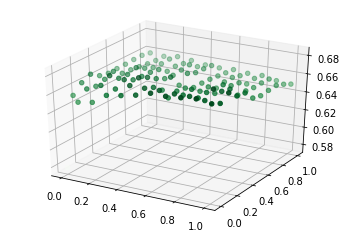

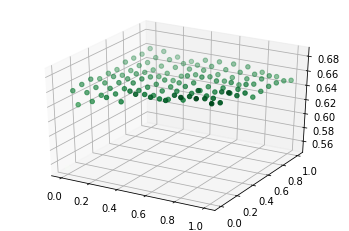

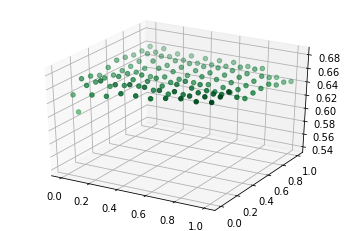

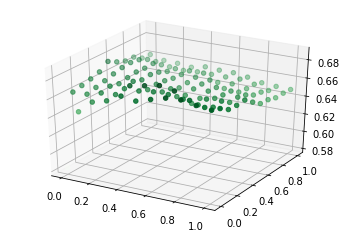

In [83]:
# let's plot the effect on macro f1 by c1 and c2
if False: # set to true to run if above cell searching settings is run
    from mpl_toolkits.mplot3d import Axes3D
    for n in range(1,5):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        # Data for three-dimensional scattered points
        xdata = [x[1][0] for x in results if x[0]==n]
        ydata = [x[1][1] for x in results if x[0]==n]
        zdata = [x[2] for x in results if x[0]==n]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [84]:
# Final results on original test data with best settings from dev set:

EXTRA_POS = True  
EXTRA_SUFFIXES = False 
PREFIXES = True 
PREVIOUS_TOKENS_TAGS = True
FOLLOWING_TOKENS_TAGS = False

min_df = 4
c1 = 0.6
c2 = 0.1

# prepare the test data:

raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq": min_df, "c1":c1, "c2":c2})  # initialize tagger with get_features function

print(get_features([x[0] for x in training_data[0]],3))  # making sure the get_features is what we think it is

# Train on ALL trainng data
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
['POS_DT', 'PRETOKEN_-2_mcqueen', 'PREPOS_-2_VBN', 'PRETOKEN_-1_provided', 'PREPOS_-1_VBN', 'WORD_a']
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [85]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.91      0.94      0.92      1274
         B-Award       0.68      0.71      0.70        66
B-Character_Name       0.71      0.43      0.53       283
      B-Director       0.86      0.84      0.85       425
         B-Genre       0.82      0.79      0.80       789
       B-Opinion       0.48      0.39      0.43       195
        B-Origin       0.44      0.35      0.39       190
          B-Plot       0.52      0.49      0.51      1577
         B-Quote       0.81      0.45      0.58        47
  B-Relationship       0.80      0.57      0.66       171
    B-Soundtrack       0.50      0.12      0.20         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.90      0.94      0.92      1553
         I-Award       0.77      0.73      0.75       147
I-Character_Name       0.75      0.49      0.59       227
      I-Director       0.91      0.86      0.88       411
         I-Ge